In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import scipy
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

Time periods:
1. Baseline period: 2005-2012
2. Intervention period: 2013-2020
3. Evaluation period: 2021-2023

# Functions

In [2]:
def getFemaleRatio(sponsoringUnits, invited_df, attendees_df, unitCol):
    index = 0
    femaleRatioInv_dict = {}
    femaleRatioAtt_dict = {}
    for i in sponsoringUnits:
        sponsoringUnitInv = invited_df[invited_df[unitCol] == i]
        sponsoringUnitAtt = attendees_df[attendees_df[unitCol] == i]
        invited_crossTab = pd.crosstab(index = sponsoringUnitInv.Year, columns = sponsoringUnitInv.Gender,
                    normalize = "index")['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_inv'})
        invited_crossTab['SponsoringUnitName'] = i
    
        attendees_crossTab = pd.crosstab(index = sponsoringUnitAtt.Year, columns = sponsoringUnitAtt.Gender,
                    normalize = 'index')['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_att'})
    
        attendees_crossTab['SponsoringUnitName'] = i
    
        invitedDict = invited_crossTab.to_dict('list')
        attendeesDict = attendees_crossTab.to_dict('list')
        femaleRatioInv_dict[index] = invitedDict
        femaleRatioAtt_dict[index] = attendeesDict
        index += 1

    return femaleRatioInv_dict, femaleRatioAtt_dict

In [3]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [4]:
#get distances
def KNN_distances(df, features):
    neighborDict = {}
    index = 0
    df_stand = df.copy()
    units = df.SponsoringUnitName.unique()

    for c in features:
        df_stand[c] = standardizeColumn(df_stand, c) #standardize data
        
    years = df.Year.unique()
    for y in years:
        year_df = df_stand[df_stand.Year == y]
        
        #do KNN
        neighbors = NearestNeighbors(n_neighbors = len(units), metric = 'manhattan').fit(year_df[features])
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(year_df[features])
        
        for i in range(0, len(units)):
            neighborDict[index] = {'SponsoringUnit': units[i], 'Year': y, 'Neighbor': kNeighbor_ind[i,1:], 'Distance': kNeighbor_dist[i,1:]} #don't select unit itself as neighbor
            index += 1
     
    neighbor_df = pd.DataFrame.from_dict(neighborDict, orient = 'index').explode(['Neighbor', 'Distance'])
    neighborIndex_df = pd.DataFrame(units).rename(columns = {0: 'NeighborUnit'})
    return neighbor_df, neighborIndex_df

In [5]:
#get similar untis within threshold
def KNN_similarUnits(df, features):
    KNN_df, unitIndex = KNN_distances(df, features) #get distance
    KNN_similarSponsUnits = KNN_df.merge(unitIndex, how = 'left', left_on = 'Neighbor', right_on = unitIndex.index)[['SponsoringUnit', 'Year', 'Distance', 'NeighborUnit']] #add name of NeighborUnit
    distances = KNN_similarSponsUnits.groupby(['SponsoringUnit', 'NeighborUnit']).sum(numeric_only = False) #sum distance for each unit and neighbor
    quantile = distances.Distance.quantile(q = 0.5) #threshold of summed distance
    similarUnits =  distances[distances.Distance <= quantile].reset_index()[['SponsoringUnit', 'NeighborUnit', 'Distance']] #df of units similar enough
  
    return similarUnits

In [7]:
def getDifferentUnits(likelihood_df, similarUnits):
    avgLikelihood = likelihood_df.groupby('SponsoringUnit').mean()
    categories = ['Low', 'High']
    
    conditions = [avgLikelihood.Avg_likelihood < 1, avgLikelihood.Avg_likelihood >= 1]

    avgLikelihood['LikelihoodCat'] = np.select(conditions, categories, default = 'Unknown')
    avgLikelihood = avgLikelihood.reset_index()
   
    likelihoodCat_df = similarUnits.merge(avgLikelihood[['SponsoringUnit', 'LikelihoodCat']], how = 'left', on = 'SponsoringUnit') #add likelihood category for sponsoring unit
    likelihoodCat_df = likelihoodCat_df.merge(avgLikelihood[['SponsoringUnit', 'LikelihoodCat']], how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit')
    similarunits_likelihood = likelihoodCat_df.rename(columns = {'SponsoringUnit_x': 'SponsoringUnit', 'LikelihoodCat_x': 'Likelihood_SponsoringUnit', 'LikelihoodCat_y': 'Likelihood_Neighbor'})[['SponsoringUnit', 'NeighborUnit', 'Distance', 'Likelihood_SponsoringUnit', 'Likelihood_Neighbor']] #rename columns + choose columns
    
    differentUnits1 = similarunits_likelihood[(similarunits_likelihood.Likelihood_SponsoringUnit == 'Low') & (similarunits_likelihood.Likelihood_Neighbor == 'High')]
    differentUnits2 = similarunits_likelihood[(similarunits_likelihood.Likelihood_SponsoringUnit == 'High') & (similarunits_likelihood.Likelihood_Neighbor == 'Low')]
    differentUnits = pd.concat([differentUnits1, differentUnits2])
    return differentUnits

In [8]:
def getRelativeChange(newVal, oldVal):
    change = (newVal - oldVal) / oldVal
    
    return change

In [9]:
def getChange(units, baseline, evaluation):
    relativeChange_dict = {}
    index = 0
    for i in units:
        baseline_att = baseline[(baseline.SponsoringUnitName == i) & (baseline.SessionType == 'attendee')] #baseline data for attendees in unit i
        
        #get gender ratio
        genderRatio = pd.crosstab(index = baseline_att.Year, columns = baseline_att.Gender, normalize = 'index')
        
        #evaluation
        eval_att = evaluation[(evaluation.SponsoringUnitName == i) & (evaluation.SessionType == 'attendee')] #data for i in evaluation period
        sessionTypeEval = pd.crosstab(index = eval_att.Year, columns = eval_att.Gender, normalize = 'index')
        relativeChange = getRelativeChange(sessionTypeEval.Female.mean(), genderRatio.Female.mean()) #get relative change of female attendees
        relativeChange_dict[index] = {'SponsoringUnit': i, 'RelativeChangeAtt': relativeChange} #save relative change in dictionary
        index += 1
        
    relativeChange_df = pd.DataFrame.from_dict(relativeChange_dict, orient = 'index')
    return relativeChange_df

In [10]:
def plotLineplot(df, unit, likelihood): #add color
    years = df.index
    sns.lineplot(data = df, x = 'Year', y = 'Female', label = unit + ": " + str(likelihood))
    plt.axvline(2012.5, color = 'black', linewidth = 1).set_linestyle("--")
    plt.axvline(2020.5, color = 'black', linewidth = 1).set_linestyle("--")
    plt.ylabel('Female ratio')
    plt.xticks(np.arange(min(years), max(years)+1, 2.0))
    
    result = stats.linregress(df.index, df.Female)
    print(result.slope)

In [38]:
def plotGenderRatio(unit_i, unit_j, df, likelihood):
    sessionType_i = df[(df.SponsoringUnitName == unit_i) & (df.SessionType == 'attendee')]
    sessionType_j = df[(df.SponsoringUnitName == unit_j) & (df.SessionType == 'attendee')]
    inv_i = df[(df.SponsoringUnitName == unit_i) & (df.SessionType == 'invited')]
    inv_j = df[(df.SponsoringUnitName == unit_j) & (df.SessionType == 'invited')]
        
    genderRatio_i = pd.crosstab(index = sessionType_i.Year, columns = sessionType_i.Gender, normalize = 'index')
    genderRatio_j = pd.crosstab(index = sessionType_j.Year, columns = sessionType_j.Gender, normalize = 'index')
    genderRatioInv_i = pd.crosstab(index = inv_i.Year, columns = inv_i.Gender, normalize = 'index')
    genderRatioInv_j = pd.crosstab(index = inv_j.Year, columns = inv_j.Gender, normalize = 'index')
    
    #average likelihood in intervention period for unit i and unit j
    likelihood_i = format(likelihood[likelihood.SponsoringUnit == unit_i]['Avg_likelihood'].mean(), '.2f')
    likelihood_j = format(likelihood[likelihood.SponsoringUnit == unit_j]['Avg_likelihood'].mean(), '.2f')
    
    plotLineplot(genderRatio_i, unit_i, likelihood_i)
    plotLineplot(genderRatio_j, unit_j, likelihood_j)
    plt.savefig("Figures/InterventionFemaleRatio/intervention_" + unit_i + "_" + unit_j + ".png", bbox_inches = 'tight')
    plt.show()

In [12]:
#load relative likelihoo + sponsoring unit data
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")
likelihood1 = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood.pkl")
likelihood2 = pd.read = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood2.pkl")
likelihood05_1 = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood05.pkl")
likelihood05_2 = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood2_05.pkl")

In [13]:
#define invited speakers and attendees
invited = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'invited']
attendees = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'attendee']

In [14]:
#number of years with data for each sponsoring unit for invited speakers and attendees
invitedYearCount = invited.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()
attendeesYearCount = attendees.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()

In [15]:
#count number of years for sponsorign units
yearCount_df = invitedYearCount[['SponsoringUnitName', 'Year']].rename(columns = {'Year': 'invitedYears'})
yearCount = yearCount_df.merge(attendeesYearCount[['SponsoringUnitName', 'Year']], how = 'outer', on = 'SponsoringUnitName').rename(columns = {'Year': 'attendeeYears'})

In [16]:
units = yearCount[(yearCount.invitedYears == 19) & (yearCount.attendeeYears == 19)].SponsoringUnitName.tolist() #sponsoring units

#only choose data for the chosen units
filteredData = sponsUnitResearchers[sponsUnitResearchers.SponsoringUnitName.isin(units)]

In [17]:
#define data for the three periods
interventionStart = 2013
interventionEnd = 2020

baselineData = filteredData[filteredData.Year < interventionStart]
interventionData = filteredData[(filteredData.Year >= interventionStart) & (filteredData.Year <= interventionEnd)]
evaluationData = filteredData[filteredData.Year > interventionEnd]

## Results for K = 1% of smallest group size

### Iteration 1

In [18]:
iteration = 1
period = 1

baselineLikelihood = likelihood1[likelihood1.Year < interventionStart]
baselineLikelihood_avg = baselineLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'BaselineLikelihood'})
interventionLikelihood = likelihood1[(likelihood1.Year >= interventionStart) & (likelihood1.Year <= interventionEnd)]
interventionLikelihood_avg = interventionLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'InterventionLikelihood'})
likelihoodChange = baselineLikelihood_avg[['SponsoringUnit', 'BaselineLikelihood']].merge(interventionLikelihood_avg[['SponsoringUnit', 'InterventionLikelihood']], how = 'inner', on = 'SponsoringUnit')

In [19]:
lowLikelihood_lim = 1
lowLikelihood_units = baselineLikelihood_avg[baselineLikelihood_avg.BaselineLikelihood < lowLikelihood_lim].SponsoringUnit.to_list()

In [20]:
#get relative change of likelihood
likelihoodChange['RelativeChange'] = getRelativeChange(likelihoodChange.InterventionLikelihood, likelihoodChange.BaselineLikelihood)

In [21]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [22]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [23]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [24]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [25]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [26]:
#add likelihood
sponsorUnit_df = sponsorUnit_df.merge(likelihood1[['Year', 'Avg_likelihood', 'SponsoringUnit']], how = 'inner', left_on = ['SponsoringUnitName', 'Year'], right_on = ['SponsoringUnit', 'Year'])

In [27]:
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att', 'Avg_likelihood']
similarUnits = KNN_similarUnits(sponsorUnit_df, features)

In [28]:
#select data for sponsoring units in the list "units"
likelihood_units = likelihood1[likelihood1.SponsoringUnit.isin(units)]

In [29]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= interventionStart) & (likelihood_units.Year <= interventionEnd)]

In [30]:
#get difference of sponsoring units in intervention period, that were similar in baseline period
similarUnits_likelihoodDiff = getDifferentUnits(interventionLikelihood, similarUnits)

In [31]:
#add relative change of relative likelihood(from baseline to intervention)
similarUnits_likelihood = similarUnits_likelihoodDiff.merge(likelihoodChange[['SponsoringUnit', 'RelativeChange']], how = 'left', on = 'SponsoringUnit')
similarUnits_likelihood = similarUnits_likelihood.merge(likelihoodChange[['SponsoringUnit', 'RelativeChange']], 
                        how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit').rename(
                        columns = {'SponsoringUnit_x': 'SponsoringUnit', 
                        'RelativeChange_x': 'SponsoringUnitLikelihood_relativeChange', 
                        'RelativeChange_y': 'NeighborLikelihood_relativeChange'})[['SponsoringUnit', 
                        'NeighborUnit', 'Distance', 'Likelihood_SponsoringUnit', 'Likelihood_Neighbor',
                        'SponsoringUnitLikelihood_relativeChange', 'NeighborLikelihood_relativeChange']]

In [32]:
#calculate likelihood delta(difference between relative change of likelihood(between sponsoring unit and neighbor))
similarUnits_likelihood['LikelihoodDelta'] = similarUnits_likelihood.SponsoringUnitLikelihood_relativeChange - similarUnits_likelihood.NeighborLikelihood_relativeChange

In [33]:
#relative change in female attendee ratio for each sponsoring unit
relativeChange = getChange(similarUnits_likelihood.SponsoringUnit.unique().tolist(), baselineData, evaluationData)

In [34]:
#add relative change of attendee ratio for unit and its neighbor to df with similar units in baseline period
similarUnit_eval  = similarUnits_likelihood.merge(relativeChange, how = 'left', on = 'SponsoringUnit') #add relative change for unit itself
similarUnit_eval = similarUnit_eval.merge(relativeChange, how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit') #add relative change for neighbor unit
similarUnit_eval = similarUnit_eval.rename(columns = {'SponsoringUnit_x': 'SponsoringUnit', 
                    'RelativeChangeAtt_x': 'RelativeChangeAtt_sponsoringUnit', 'RelativeChangeAtt_y': 
                    'RelativeChangeAtt_neighbor'})[['SponsoringUnit', 'NeighborUnit', 'Distance', 
                     'Likelihood_SponsoringUnit', 'Likelihood_Neighbor', 'LikelihoodDelta', 
                    'RelativeChangeAtt_sponsoringUnit', 'RelativeChangeAtt_neighbor']] #rename columns + select columns

similarUnit_eval['RelativeChangeAtt_Delta'] = similarUnit_eval.RelativeChangeAtt_sponsoringUnit - similarUnit_eval.RelativeChangeAtt_neighbor

In [35]:
#only plot those, that were low in baseline population
sortedEvalUnits = similarUnit_eval[similarUnit_eval.Likelihood_SponsoringUnit == 'High']
lowUnits = sortedEvalUnits[(sortedEvalUnits.SponsoringUnit.isin(lowLikelihood_units)) & (sortedEvalUnits.NeighborUnit.isin(lowLikelihood_units))] #units with < 1 in avg likelihood in baseline period

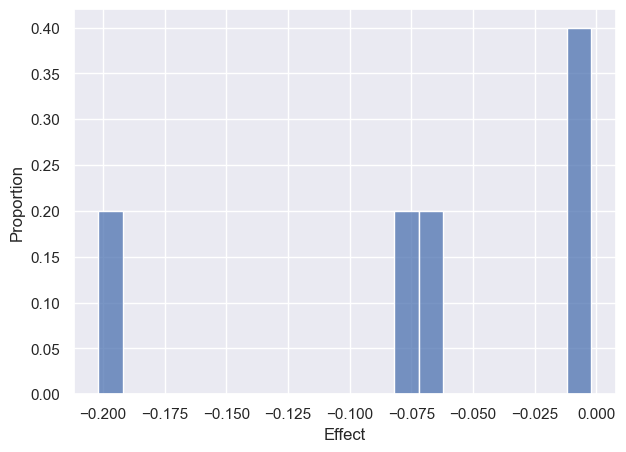

In [36]:
#sort units(high, low)
sns.histplot(data = lowUnits, x = 'RelativeChangeAtt_Delta', binwidth = 0.01, stat = 'proportion')
plt.xlabel("Effect")
plt.savefig('Figures/effectHist' + str(period) + 'i' + str(iteration) + '.png', bbox_inches='tight')
plt.show()

In [37]:
len(lowUnits[lowUnits.RelativeChangeAtt_Delta >= 0])/len(lowUnits.RelativeChangeAtt_Delta)

0.0

0.0036377112161955828
0.00434283269159297


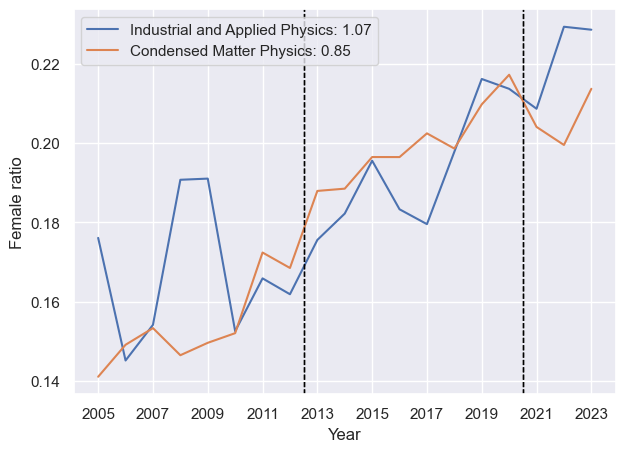

0.0037052556478318157
0.003619811021069349


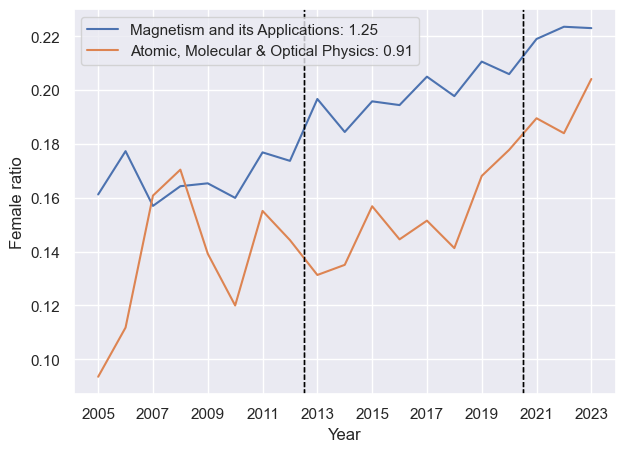

0.0037052556478318157
0.00434283269159297


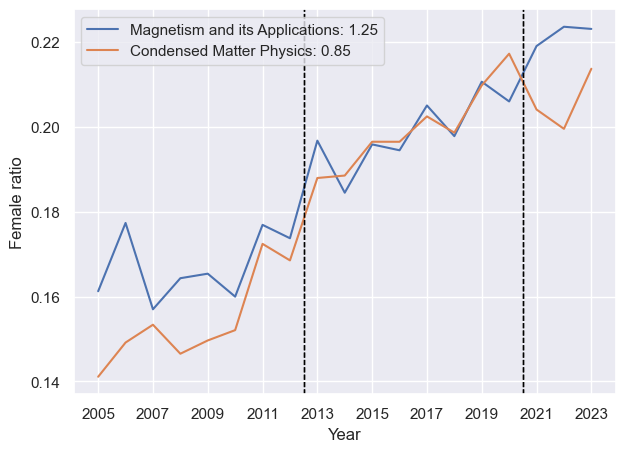

0.003751639347051402
0.00434283269159297


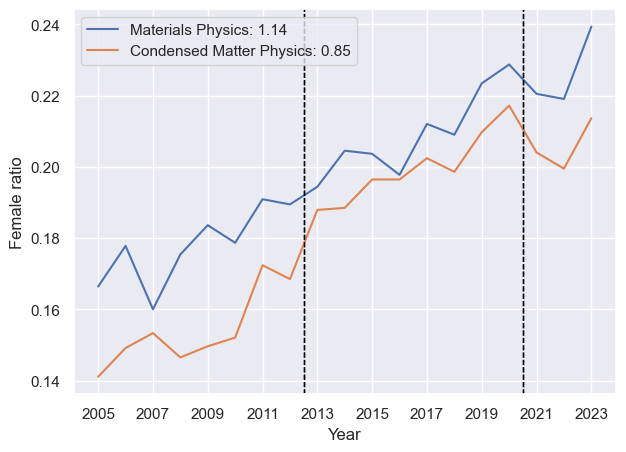

0.0032976659714697544
0.003619811021069349


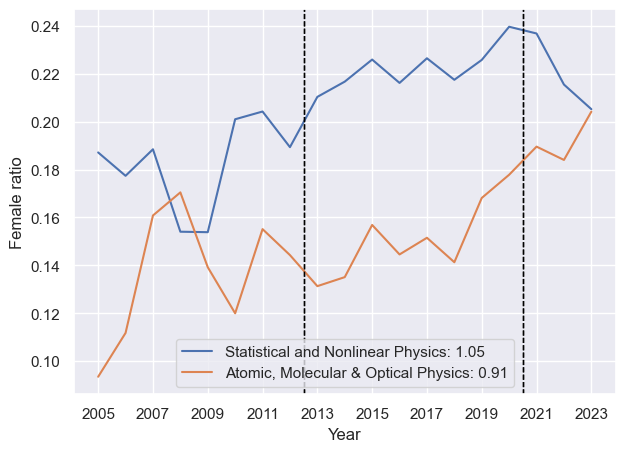

In [39]:
unitsToPlot = lowUnits.to_dict('records')

for i in unitsToPlot:
    unit_i = i['SponsoringUnit']
    unit_j = i['NeighborUnit']
    
    plotGenderRatio(unit_i, unit_j, sponsUnitResearchers, interventionLikelihood)

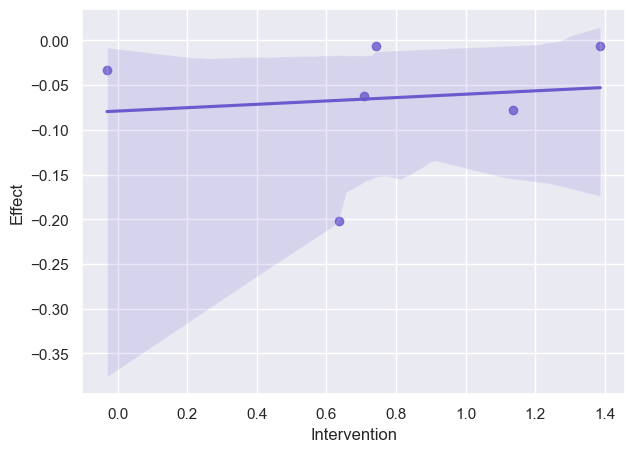

In [150]:
linReg = sns.regplot(data = sortedEvalUnits, x = 'LikelihoodDelta', y = 'RelativeChangeAtt_Delta', color = 'slateblue', ci=95)
slope, intercept, r, p, sterr = scipy.stats.linregress(x=linReg.get_lines()[0].get_xdata(),
                                                       y=linReg.get_lines()[0].get_ydata())
plt.xlabel("Intervention")
plt.ylabel("Effect")
plt.savefig('Figures/effectInterventionPeriods' + str(period) + 'i' + str(iteration) + '.png', bbox_inches='tight')
plt.show()

In [151]:
print(slope)

0.018829354001054975


In [152]:
x = sortedEvalUnits.LikelihoodDelta.values
X = sm.add_constant(x)
y = sortedEvalUnits.RelativeChangeAtt_Delta.values

In [153]:
model = sm.OLS(y, X).fit()
confidence_interval_slope = model.conf_int(alpha=0.05)[1]
confidence_interval_slope

array([-0.18891744,  0.22657615])

### Iteration 2

In [379]:
iteration = 2
period = 1

baselineLikelihood = likelihood2[likelihood2.Year < interventionStart]
baselineLikelihood_avg = baselineLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'BaselineLikelihood'})
interventionLikelihood = likelihood2[(likelihood2.Year >= interventionStart) & (likelihood2.Year <= interventionEnd)]
interventionLikelihood_avg = interventionLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'InterventionLikelihood'})
likelihoodChange = baselineLikelihood_avg[['SponsoringUnit', 'BaselineLikelihood']].merge(interventionLikelihood_avg[['SponsoringUnit', 'InterventionLikelihood']], how = 'inner', on = 'SponsoringUnit')

In [380]:
lowLikelihood_lim = 1
lowLikelihood_units = baselineLikelihood_avg[baselineLikelihood_avg.BaselineLikelihood < lowLikelihood_lim].SponsoringUnit.to_list()

In [381]:
#get relative change of likelihood
likelihoodChange['RelativeChange'] = getRelativeChange(likelihoodChange.InterventionLikelihood, likelihoodChange.BaselineLikelihood)

In [382]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [383]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [384]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [385]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [386]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [387]:
#add likelihood
sponsorUnit_df = sponsorUnit_df.merge(likelihood2[['Year', 'Avg_likelihood', 'SponsoringUnit']], how = 'inner', left_on = ['SponsoringUnitName', 'Year'], right_on = ['SponsoringUnit', 'Year'])

In [388]:
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att', 'Avg_likelihood']
similarUnits = KNN_similarUnits(sponsorUnit_df, features)

In [389]:
#select data for sponsoring units in the list "units"
likelihood_units = likelihood2[likelihood2.SponsoringUnit.isin(units)]

In [390]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= interventionStart) & (likelihood_units.Year <= interventionEnd)]

In [391]:
#get difference of sponsoring units in intervention period, that were similar in baseline period
similarUnits_likelihoodDiff = getDifferentUnits(interventionLikelihood, similarUnits)

In [392]:
#add relative change of relative likelihood(from baseline to intervention)
similarUnits_likelihood = similarUnits_likelihoodDiff.merge(likelihoodChange[['SponsoringUnit', 'RelativeChange']], how = 'left', on = 'SponsoringUnit')
similarUnits_likelihood = similarUnits_likelihood.merge(likelihoodChange[['SponsoringUnit', 'RelativeChange']], 
                        how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit').rename(
                        columns = {'SponsoringUnit_x': 'SponsoringUnit', 
                        'RelativeChange_x': 'SponsoringUnitLikelihood_relativeChange', 
                        'RelativeChange_y': 'NeighborLikelihood_relativeChange'})[['SponsoringUnit', 
                        'NeighborUnit', 'Distance', 'Likelihood_SponsoringUnit', 'Likelihood_Neighbor',
                        'SponsoringUnitLikelihood_relativeChange', 'NeighborLikelihood_relativeChange']]

In [393]:
#calculate likelihood delta(difference between relative change of likelihood(between sponsoring unit and neighbor))
similarUnits_likelihood['LikelihoodDelta'] = similarUnits_likelihood.SponsoringUnitLikelihood_relativeChange - similarUnits_likelihood.NeighborLikelihood_relativeChange

In [394]:
#relative change in female attendee ratio for each sponsoring unit
relativeChange = getChange(similarUnits_likelihood.SponsoringUnit.unique().tolist(), baselineData, evaluationData)

In [395]:
#add relative change of attendee ratio for unit and its neighbor to df with similar units in baseline period
similarUnit_eval  = similarUnits_likelihood.merge(relativeChange, how = 'left', on = 'SponsoringUnit') #add relative change for unit itself
similarUnit_eval = similarUnit_eval.merge(relativeChange, how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit') #add relative change for neighbor unit
similarUnit_eval = similarUnit_eval.rename(columns = {'SponsoringUnit_x': 'SponsoringUnit', 
                    'RelativeChangeAtt_x': 'RelativeChangeAtt_sponsoringUnit', 'RelativeChangeAtt_y': 
                    'RelativeChangeAtt_neighbor'})[['SponsoringUnit', 'NeighborUnit', 'Distance', 
                     'Likelihood_SponsoringUnit', 'Likelihood_Neighbor', 'LikelihoodDelta', 
                    'RelativeChangeAtt_sponsoringUnit', 'RelativeChangeAtt_neighbor']] #rename columns + select columns

similarUnit_eval['RelativeChangeAtt_Delta'] = similarUnit_eval.RelativeChangeAtt_sponsoringUnit - similarUnit_eval.RelativeChangeAtt_neighbor

In [396]:
#only plot those, that were low in baseline population
sortedEvalUnits = similarUnit_eval[similarUnit_eval.Likelihood_SponsoringUnit == 'High']
lowUnits = sortedEvalUnits[(sortedEvalUnits.SponsoringUnit.isin(lowLikelihood_units)) & (sortedEvalUnits.NeighborUnit.isin(lowLikelihood_units))] #units with < 1 in avg likelihood in baseline period

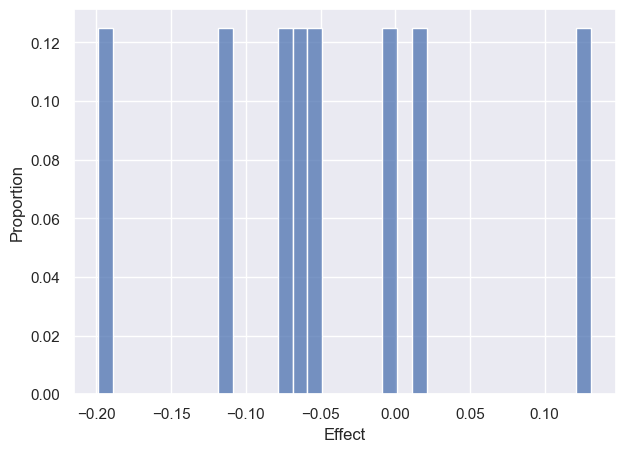

In [397]:
#sort units(high, low)
sns.histplot(data = lowUnits, x = 'RelativeChangeAtt_Delta', binwidth = 0.01, stat = 'proportion')
plt.xlabel("Effect")
plt.savefig('Figures/effectHist' + str(period) + 'i' + str(iteration) + '.png', bbox_inches='tight')
plt.show()

In [173]:
len(lowUnits[lowUnits.RelativeChangeAtt_Delta >= 0])/len(lowUnits.RelativeChangeAtt_Delta)

0.375

In [174]:
unitsToPlot = sortedEvalUnits.to_dict('records')

0.002184654585684913
0.0036377112161955828


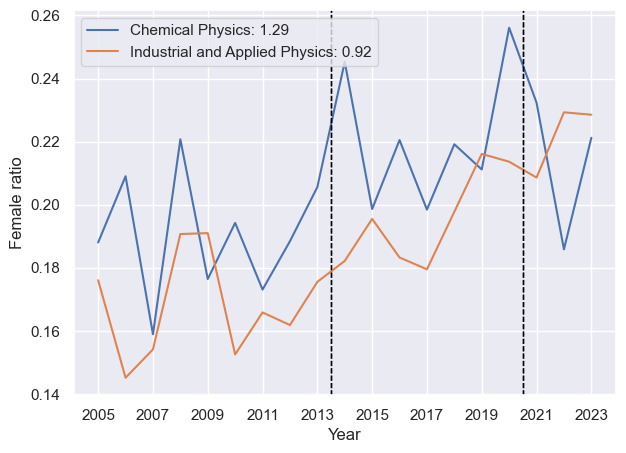

0.002184654585684913
0.0032976659714697544


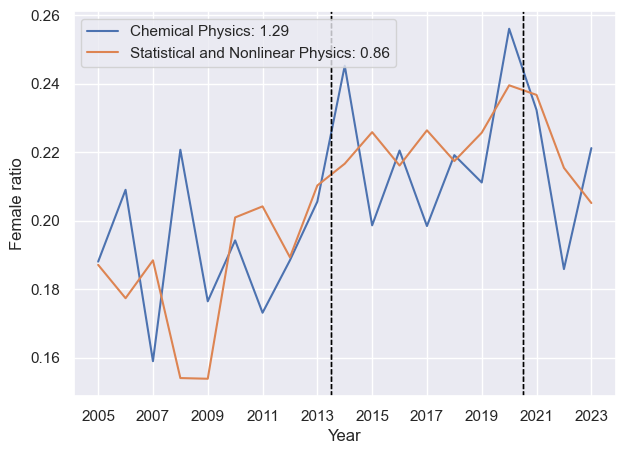

0.004760576032877645
0.0036377112161955828


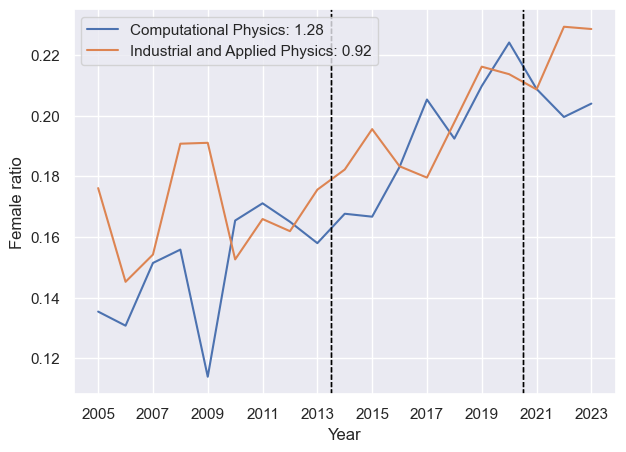

0.004760576032877645
0.0032976659714697544


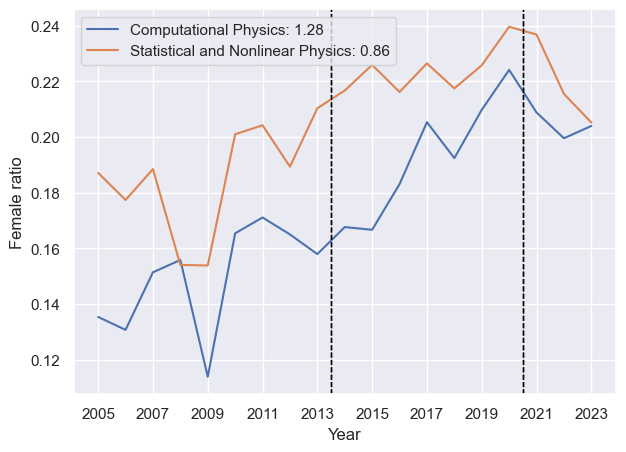

0.0037052556478318157
0.0036377112161955828


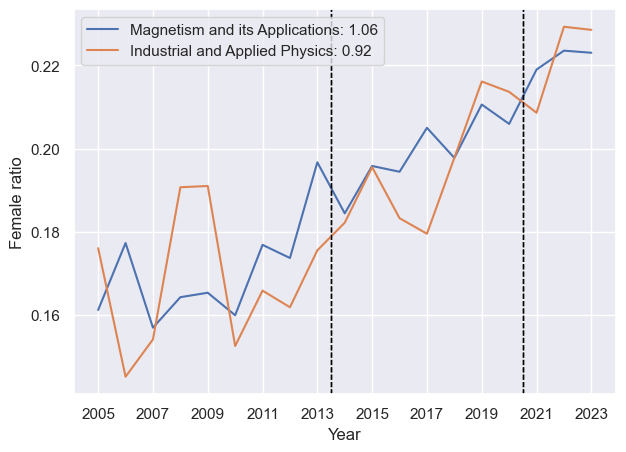

0.0037052556478318157
0.0032976659714697544


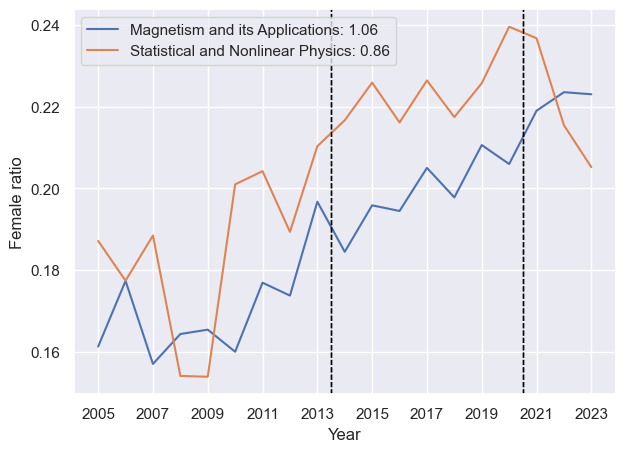

0.003751639347051402
0.00434283269159297


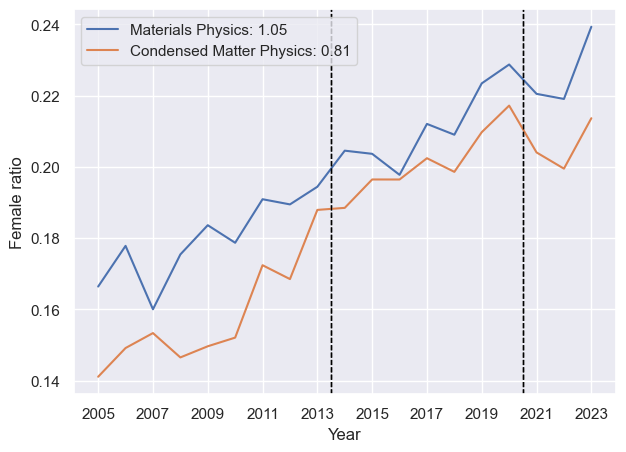

0.003751639347051402
0.0036377112161955828


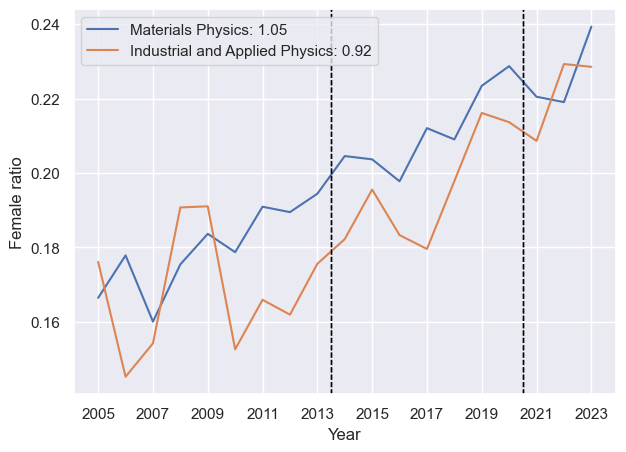

0.0035266374218203933
0.0036377112161955828


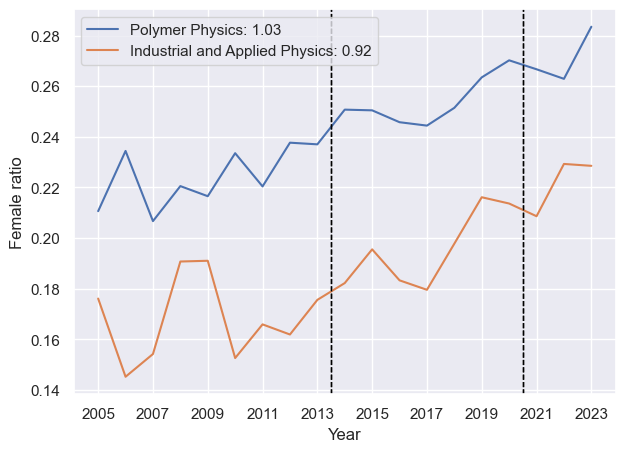

0.0035266374218203933
0.0032976659714697544


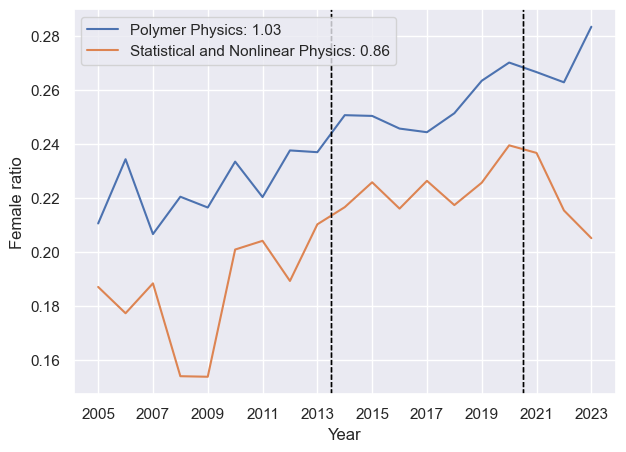

In [175]:
for i in unitsToPlot:
    unit_i = i['SponsoringUnit']
    unit_j = i['NeighborUnit']
    
    plotGenderRatio(unit_i, unit_j, sponsUnitResearchers, interventionLikelihood)

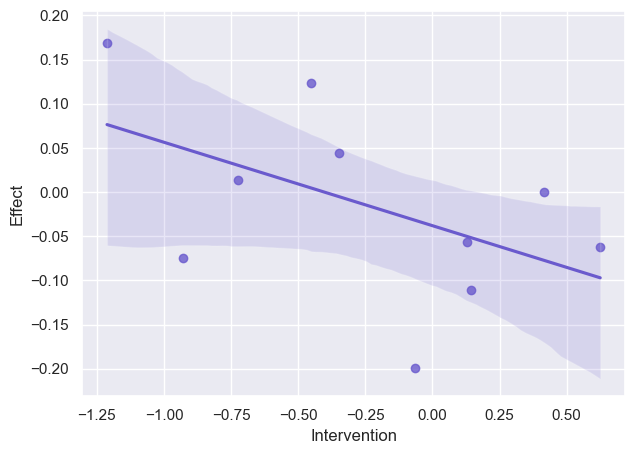

In [176]:
linReg = sns.regplot(data = sortedEvalUnits, x = 'LikelihoodDelta', y = 'RelativeChangeAtt_Delta', color = 'slateblue', ci=95)
slope, intercept, r, p, sterr = scipy.stats.linregress(x=linReg.get_lines()[0].get_xdata(),
                                                       y=linReg.get_lines()[0].get_ydata())
plt.xlabel("Intervention")
plt.ylabel("Effect")
plt.savefig('Figures/effectInterventionPeriods' + str(period) + 'i' + str(iteration) + '.png', bbox_inches='tight')
plt.show()

In [177]:
print(slope)

-0.09441971640034198


In [178]:
x = sortedEvalUnits.LikelihoodDelta.values
X = sm.add_constant(x)
y = sortedEvalUnits.RelativeChangeAtt_Delta.values

In [179]:
model = sm.OLS(y, X).fit()
confidence_interval_slope = model.conf_int(alpha=0.05)[1]
confidence_interval_slope

array([-0.2230924 ,  0.03425297])

## Results for K = 5% of smallest group size

### Iteration 1

In [232]:
#define data for the three periods
interventionStart = 2018
interventionEnd = 2021

baselineData = filteredData[filteredData.Year < interventionStart]
interventionData = filteredData[(filteredData.Year >= interventionStart) & (filteredData.Year <= interventionEnd)]
evaluationData = filteredData[filteredData.Year > interventionEnd]

In [233]:
baselineLikelihood = likelihood05_1[likelihood05_1.Year < interventionStart]
baselineLikelihood_avg = baselineLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'BaselineLikelihood'})
interventionLikelihood = likelihood05_1[(likelihood05_1.Year >= interventionStart) & (likelihood05_1.Year <= interventionEnd)]
interventionLikelihood_avg = interventionLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'InterventionLikelihood'})
likelihoodChange = baselineLikelihood_avg[['SponsoringUnit', 'BaselineLikelihood']].merge(interventionLikelihood_avg[['SponsoringUnit', 'InterventionLikelihood']], how = 'inner', on = 'SponsoringUnit')

In [235]:
lowLikelihood_lim = 1
lowLikelihood_units = baselineLikelihood_avg[baselineLikelihood_avg.BaselineLikelihood < lowLikelihood_lim].SponsoringUnit.to_list()

In [237]:
#get relative change of likelihood
likelihoodChange['RelativeChange'] = getRelativeChange(likelihoodChange.InterventionLikelihood, likelihoodChange.BaselineLikelihood)

In [238]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [239]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [240]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [241]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [242]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [244]:
#add likelihood
sponsorUnit_df = sponsorUnit_df.merge(likelihood05_1[['Year', 'Avg_likelihood', 'SponsoringUnit']], how = 'inner', left_on = ['SponsoringUnitName', 'Year'], right_on = ['SponsoringUnit', 'Year'])

In [246]:
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att', 'Avg_likelihood']
similarUnits = KNN_similarUnits(sponsorUnit_df, features)

In [247]:
#select data for sponsoring units in the list "units"
likelihood_units = likelihood05_1[likelihood05_1.SponsoringUnit.isin(units)]

In [250]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= interventionStart) & (likelihood_units.Year <= interventionEnd)]

In [264]:
#get difference of sponsoring units in intervention period, that were similar in baseline period
similarUnits_likelihoodDiff = getDifferentUnits(interventionLikelihood, similarUnits)

No pairs left with different effort in intervention period

### Iteration 2

In [266]:
baselineLikelihood = likelihood05_2[likelihood05_2.Year < interventionStart]
baselineLikelihood_avg = baselineLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'BaselineLikelihood'})
interventionLikelihood = likelihood05_2[(likelihood05_2.Year >= interventionStart) & (likelihood05_2.Year <= interventionEnd)]
interventionLikelihood_avg = interventionLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'InterventionLikelihood'})
likelihoodChange = baselineLikelihood_avg[['SponsoringUnit', 'BaselineLikelihood']].merge(interventionLikelihood_avg[['SponsoringUnit', 'InterventionLikelihood']], how = 'inner', on = 'SponsoringUnit')

In [267]:
lowLikelihood_lim = 1
lowLikelihood_units = baselineLikelihood_avg[baselineLikelihood_avg.BaselineLikelihood < lowLikelihood_lim].SponsoringUnit.to_list()

In [268]:
#get relative change of likelihood
likelihoodChange['RelativeChange'] = getRelativeChange(likelihoodChange.InterventionLikelihood, likelihoodChange.BaselineLikelihood)

In [269]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [270]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [271]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [272]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

In [273]:
femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [274]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [275]:
#add likelihood
sponsorUnit_df = sponsorUnit_df.merge(likelihood05_2[['Year', 'Avg_likelihood', 'SponsoringUnit']], how = 'inner', left_on = ['SponsoringUnitName', 'Year'], right_on = ['SponsoringUnit', 'Year'])

In [277]:
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att', 'Avg_likelihood']
similarUnits = KNN_similarUnits(sponsorUnit_df, features)

In [279]:
#select data for sponsoring units in the list "units"
likelihood_units = likelihood05_2[likelihood05_2.SponsoringUnit.isin(units)]

In [280]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= interventionStart) & (likelihood_units.Year <= interventionEnd)]

In [292]:
interventionLikelihood.groupby('SponsoringUnit').mean()

,K,Year,Avg_likelihood,STD_likelihood,SEM_likelihood
SponsoringUnit,,,,,
"Atomic, Molecular & Optical Physics",2.0,2019.5,0.876519,0.297926,0.009421
Chemical Physics,4.0,2019.5,1.420272,0.442280,0.013986
Computational Physics,5.0,2019.5,1.292538,0.314108,0.009933
Condensed Matter Physics,14.0,2019.5,1.025422,0.251132,0.007941
Industrial and Applied Physics,6.0,2019.5,1.338989,0.493287,0.015599
Magnetism and its Applications,7.0,2019.5,1.514502,0.456480,0.014435
Materials Physics,15.0,2019.5,1.465829,0.317466,0.010039
Polymer Physics,6.0,2019.5,1.041083,0.302178,0.009556
Statistical and Nonlinear Physics,4.0,2019.5,1.075423,0.329340,0.010415


In [281]:
#get difference of sponsoring units in intervention period, that were similar in baseline period
similarUnits_likelihoodDiff = getDifferentUnits(interventionLikelihood, similarUnits)

No pairs left with different effort in intervention period